# Module 3 - Data Analytics 1.0

#### Created by: Dody Harianto

In this notebook, we will examine the features that contribute to diabetes disease progression (after one year). At the end of the notebook, we'll look at the features importance, so we need to install a library called `eli5`.

In [ ]:
!pip install eli5

In [ ]:
# Data Analysis
import pandas as pd
import numpy as np

# Data Visualization
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set_style('darkgrid')

# Dataset
from sklearn.datasets import load_diabetes

# Hypothesis Testing
from scipy.stats import pearsonr

# Simple Modelling
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import eli5
from eli5.sklearn import PermutationImportance

Load the diabetes dataset from `sklearn.datasets`.

In [ ]:
diabetes_data = load_diabetes()
diabetes_data

{'DESCR': '.. _diabetes_dataset:\n\nDiabetes dataset\n----------------\n\nTen baseline variables, age, sex, body mass index, average blood\npressure, and six blood serum measurements were obtained for each of n =\n442 diabetes patients, as well as the response of interest, a\nquantitative measure of disease progression one year after baseline.\n\n**Data Set Characteristics:**\n\n  :Number of Instances: 442\n\n  :Number of Attributes: First 10 columns are numeric predictive values\n\n  :Target: Column 11 is a quantitative measure of disease progression one year after baseline\n\n  :Attribute Information:\n      - age     age in years\n      - sex\n      - bmi     body mass index\n      - bp      average blood pressure\n      - s1      tc, total serum cholesterol\n      - s2      ldl, low-density lipoproteins\n      - s3      hdl, high-density lipoproteins\n      - s4      tch, total cholesterol / HDL\n      - s5      ltg, possibly log of serum triglycerides level\n      - s6      glu, b

The type of the data is a bunch (similar to dictionary), it is better to convert it into Pandas DataFrame.

In [ ]:
type(diabetes_data)

sklearn.utils.Bunch

In [ ]:
diabetes_df = pd.DataFrame(data = diabetes_data['data'], columns = diabetes_data['feature_names'])
diabetes_df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


In [ ]:
diabetes_df['disease_progression'] = diabetes_data['target']
diabetes_df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,disease_progression
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


The name of columns are mostly in the short version. In order to understand more about the data, we can view the description of `diabetes_data`.

In [ ]:
print(diabetes_data.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

Besides the description, we can also display the glimpse information about the dataset using `.info()`. From here, we can know the data types of features as well as checking whether there are missing values. In this case, all features (and target) don't have any missing values. 

In [ ]:
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  442 non-null    float64
 1   sex                  442 non-null    float64
 2   bmi                  442 non-null    float64
 3   bp                   442 non-null    float64
 4   s1                   442 non-null    float64
 5   s2                   442 non-null    float64
 6   s3                   442 non-null    float64
 7   s4                   442 non-null    float64
 8   s5                   442 non-null    float64
 9   s6                   442 non-null    float64
 10  disease_progression  442 non-null    float64
dtypes: float64(11)
memory usage: 38.1 KB


In [ ]:
diabetes_df['disease_progression'].min(), diabetes_df['disease_progression'].max()

(25.0, 346.0)

In [ ]:
diabetes_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,442.0,-3.634285e-16,0.047619,-0.107226,-0.037299,0.005383,0.038076,0.110727
sex,442.0,1.308343e-16,0.047619,-0.044642,-0.044642,-0.044642,0.050680,0.050680
bmi,442.0,-8.045349e-16,0.047619,-0.090275,-0.034229,-0.007284,0.031248,0.170555
bp,442.0,1.281655e-16,0.047619,-0.112400,-0.036656,-0.005671,0.035644,0.132044
s1,442.0,-8.835316e-17,0.047619,-0.126781,-0.034248,-0.004321,0.028358,0.153914
s2,442.0,1.327024e-16,0.047619,-0.115613,-0.030358,-0.003819,0.029844,0.198788
s3,442.0,-4.574646e-16,0.047619,-0.102307,-0.035117,-0.006584,0.029312,0.181179
s4,442.0,3.777301e-16,0.047619,-0.076395,-0.039493,-0.002592,0.034309,0.185234
s5,442.0,-3.830854e-16,0.047619,-0.126097,-0.033249,-0.001948,0.032433,0.133599
s6,442.0,-3.412882e-16,0.047619,-0.137767,-0.033179,-0.001078,0.027917,0.135612


# Main Question
What are the factors that contribute to the disease progression of a diabetes patient?

Questions and/or Assumptions:

1. Does higher body mass index (BMI) increase the risk of the diabetes disease progression?
2. Do people with older age tend to have higher possibility to be diagnosed as having diabetes?
3. Can a stable blood pressure reduce the risk of diabetes disease?
4. What is the most impactful blood serum measure towards the diabetes disease progression?
5. Does gender matter?

First, let's check the distribution of the diabetes disease progression since it is the target variable.

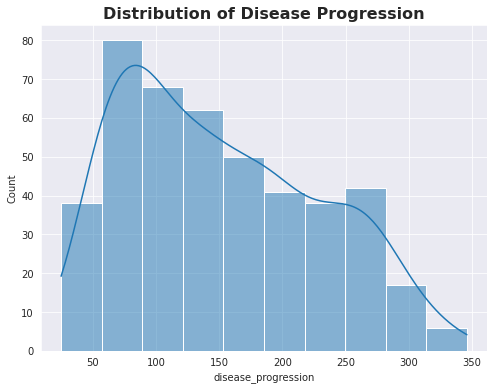

In [ ]:
plt.figure(figsize = (8, 6))
sns.histplot(x = 'disease_progression', data = diabetes_df, kde = True)
plt.title('Distribution of Disease Progression', fontsize = 16, fontweight = 'bold')
plt.show()

The distribution of age shows that there are no groups of people that are far from the most of the data points (no outliers), and the distribution looks like a bell shape, indicates that it is close to normal distribution.

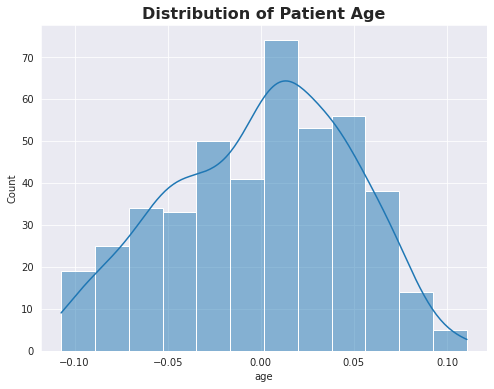

In [ ]:
plt.figure(figsize = (8, 6))
sns.histplot(x = 'age', data = diabetes_df, kde = True)
plt.title('Distribution of Patient Age', fontsize = 16, fontweight = 'bold')
plt.show()

Check out the distribution of sex.

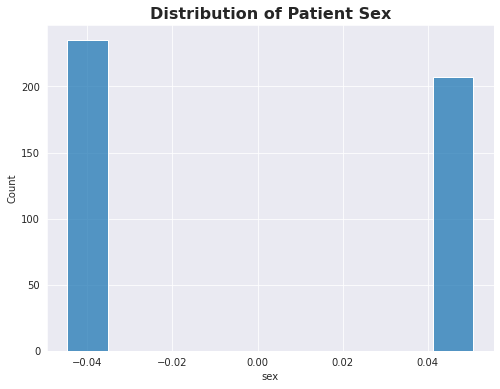

In [ ]:
plt.figure(figsize = (8, 6))
sns.histplot(x = 'sex', data = diabetes_df)
plt.title('Distribution of Patient Sex', fontsize = 16, fontweight = 'bold')
plt.show()

From the histogram above, we can see that there are two values with high density. Let's check the unique values of sex.

In [ ]:
diabetes_df['sex'].unique()

array([ 0.05068012, -0.04464164])

Apparently, there are only two unique values in the sex column but unfortunately there is no further information about which gender represents which value.

# 1. Does higher body mass index (BMI) increase the risk of the diabetes disease progression?

In [ ]:
diabetes_df['sex'] = diabetes_df['sex'].astype('category')

Create a function to examine the correlation between two variables using scatter plot.

In [ ]:
def create_scatter_plot(df, col1, col2, rsuffix, hue = None):
    plt.figure(figsize = (8, 6))
    sns.scatterplot(x = col1, y = col2, data = df, hue = hue)
    plt.title('Disease Progression vs. ' + rsuffix, fontsize = 16, fontweight = 'bold')
    plt.show()

    if hue is not None:
        g = sns.FacetGrid(df, col = hue, hue = hue)
        g.map(sns.regplot, col1, col2)
        g.set_titles('Divided by ' + hue)
        plt.show()

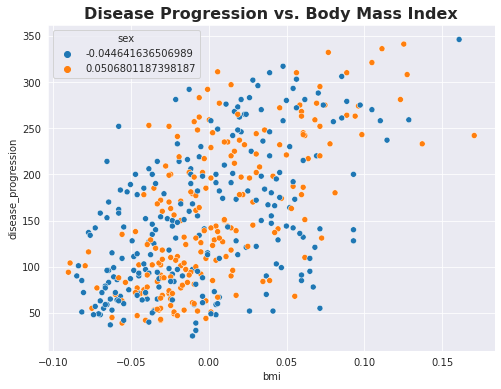

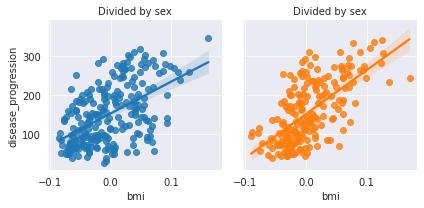

In [ ]:
create_scatter_plot(diabetes_df, 'bmi', 'disease_progression', 'Body Mass Index', 'sex')

We can see that there is a positive correlation of the body mass index and diabetes disease, for both gender (male and female). 

We can create an interactive visualization plot using the `plotly.express` library to enable us to view each point in more detail.

In [ ]:
px.scatter(diabetes_df, x = 'bmi', y = 'disease_progression', color = 'sex', 
           title = 'Disease Progression by Body Mass Index')

# 2. Do people with older age tend to have higher possibility to be diagnosed as having diabetes?

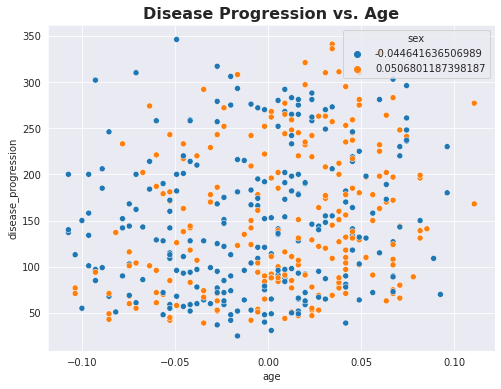

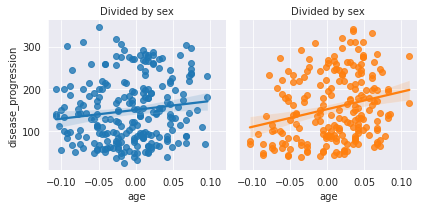

In [ ]:
create_scatter_plot(diabetes_df, 'age', 'disease_progression', 'Age', hue = 'sex')

The scatter plot shows that there is a little relationship 

In [ ]:
px.scatter(diabetes_df, x = 'age', y = 'disease_progression', color = 'sex', 
           title = 'Disease Progression by Body Mass Index')

# 3. Can a stable blood pressure reduce the risk of diabetes disease?

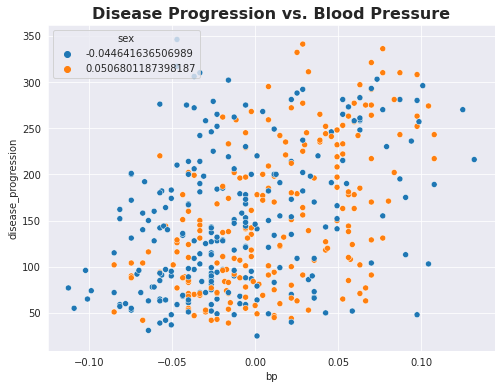

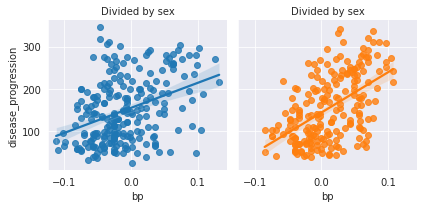

In [ ]:
create_scatter_plot(diabetes_df, 'bp', 'disease_progression', 'Blood Pressure', hue = 'sex')

In [ ]:
px.scatter(diabetes_df, x = 'age', y = 'disease_progression', color = 'sex', 
           title = 'Disease Progression vs. Blood Pressure')

# 4. What is the most impactful blood serum measure towards the diabetes disease progression?

To check the relationship between two numerical variables, usually we create a scatter plot. But now, let's do something different. Another way is to perform statistical experiments and significance testing.

There are several methods, but, **what method to use?**

We can use the Pearson R Statistical Test if the data meets following assumptions:
1. There is a linear relationship between two variables
2. The data is close to normal distribution (or at least there are no outliers).

So let's check the distribution of the blood serums.

In [ ]:
def check_distribution(df, column):
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 6))
    fig.suptitle('Distribution of ' + column, fontsize = 'xx-large', fontweight = 'bold')

    sns.kdeplot(x = column, data = df, ax = ax[0])
    ax[0].set_title('Density Plot', color = 'blue', fontweight = 'bold')
    ax[0].set_xlabel(column, fontweight = 'bold')

    sns.violinplot(x = column, data = df, ax = ax[1])
    ax[1].set_title('Violin Plot', color = 'blue', fontweight = 'bold')
    ax[1].set_xlabel(column, fontweight = 'bold')

    plt.show()

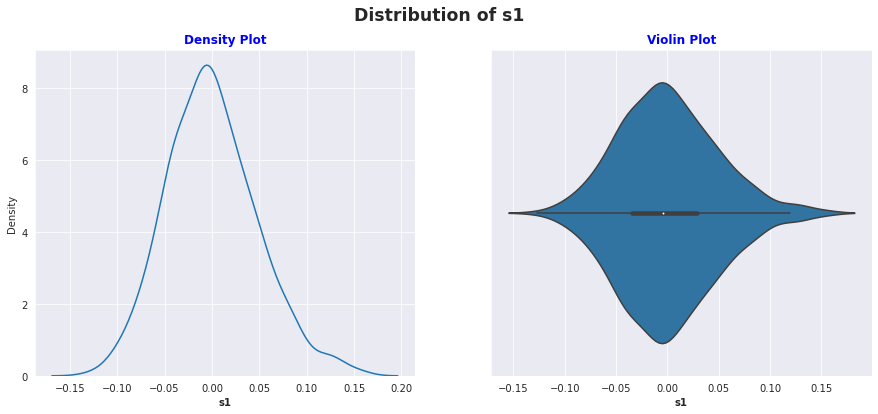

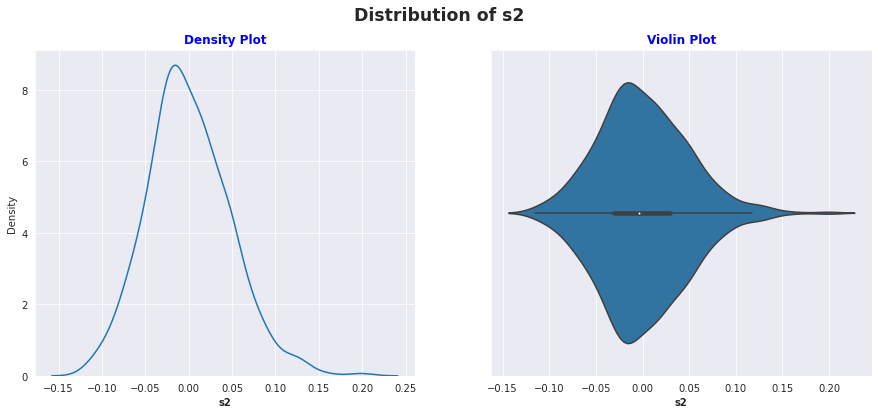

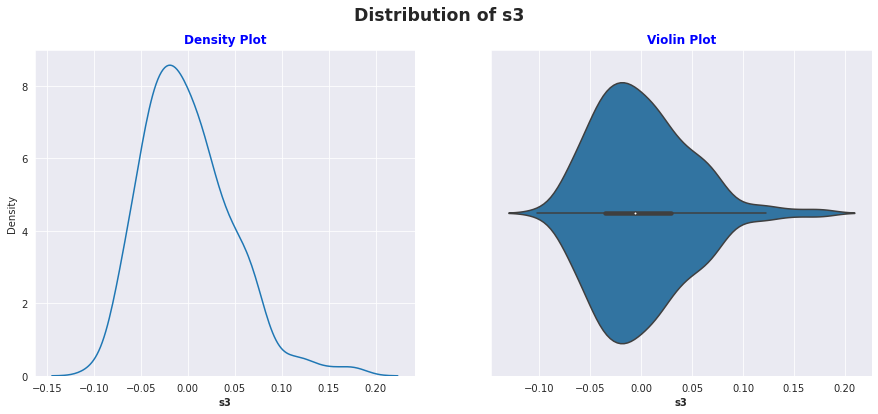

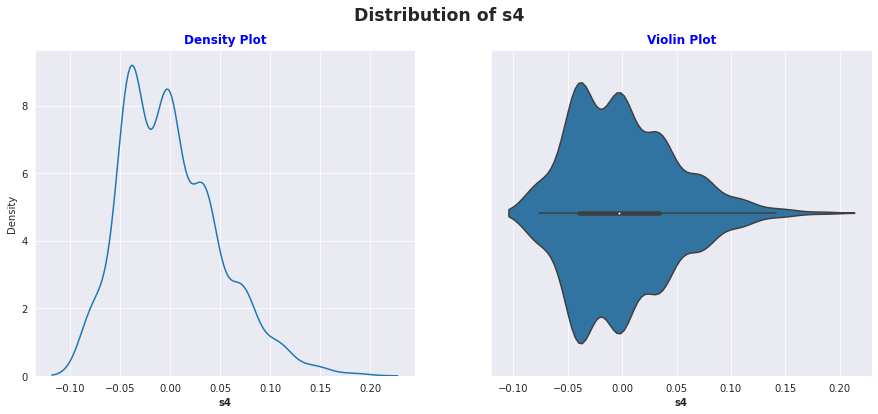

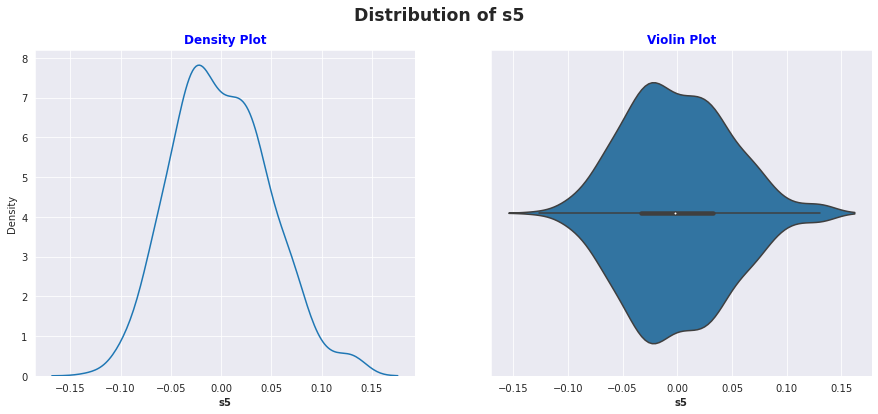

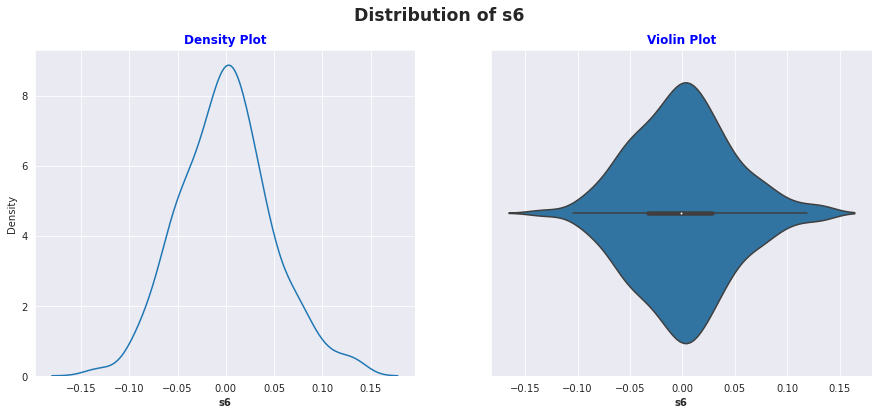

In [ ]:
blood_serums = ['s' + str(i) for i in range(1, 7)]
for serum in blood_serums:
    check_distribution(diabetes_df, serum)

All the blood serums (`s1`, `s2`, `s3`, `s4`, `s5`, and `s6`) seem not to have any extreme outliers, so we can go with the Pearson R method.

Otherwise, we can use other methods that do not depend on the variable distribution, such as Kendall's tau or Spearman's rho.

**Hypotheses**
H0: The relationship between both variables is not significant.
H1: The relationship between both variables is significant.

P-value < alpha? Reject H0.

In [ ]:
alpha = 0.05
significant_features = []
for serum in blood_serums:
    r_statistic, p_value = pearsonr(diabetes_df[serum], diabetes_df['disease_progression'])
    print('Column: {}'.format(serum))
    print('=' * 35)
    print('R Statistic: {}'.format(r_statistic))
    print('p-value: {}\n'.format(p_value))
    
    if p_value < alpha:
        significant_features.append(serum)

Column: s1
R Statistic: 0.2120224810145507
p-value: 6.920711787756615e-06

Column: s2
R Statistic: 0.1740535869687425
p-value: 0.00023598480959842948

Column: s3
R Statistic: -0.3947892506709184
p-value: 6.1628646951821016e-18

Column: s4
R Statistic: 0.43045288474477295
p-value: 2.3042532817525966e-21

Column: s5
R Statistic: 0.5658834252428095
p-value: 8.823754157324818e-39

Column: s6
R Statistic: 0.38248348424858103
p-value: 7.58008326608111e-17



In [ ]:
significant_features

['s1', 's2', 's3', 's4', 's5', 's6']

In [ ]:
p_values = [pearsonr(diabetes_df[serum], diabetes_df['disease_progression'])[1] for serum in blood_serums]

serums_correlation_df = pd.DataFrame({
    'Column': blood_serums,
    'P-Value': p_values
})

serums_correlation_df

,Column,P-Value
0,s1,6.920712e-06
1,s2,2.359848e-04
2,s3,6.162865e-18
3,s4,2.304253e-21
4,s5,8.823754e-39
5,s6,7.580083e-17


`s5` is the column with the most significant relationship with `disease_progression` column as the p-value is the smallest. 

# 5. Does gender matter?

From most of the visualizations above, we can see that the relationship between an arbitrary variable and `disease_progression` show a quite similar pattern, despite being divided by sex / gender.

But, how about the correlation between `sex` itself with the `disease_progression`?

In [ ]:
def get_pie_plot_components (df, categorical):
    numbers = list(diabetes_df[categorical].value_counts().values)
    labels = list(diabetes_df[categorical].value_counts().index)
    return numbers, labels

def create_bar_and_pie_chart (df, categorical, numerical):
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 6))

    numbers, labels = get_pie_plot_components(df, categorical)
    ax[0].pie(numbers, labels = labels, autopct = '%.1f%%')
    ax[0].set_title('Pie Chart', color = 'blue', fontweight = 'bold')

    sns.barplot(x = categorical, y = numerical, data = df, ax = ax[1], ci = None)
    ax[1].set_title('Bar Chart', color = 'blue', fontweight = 'bold')
    ax[1].set_xlabel('Sex', color = 'red', fontweight = 'bold')
    ax[1].set_ylabel('Disease Progression', color = 'red', fontweight = 'bold')

    fig.suptitle('Disease Progression by Age', fontsize = 'xx-large', fontweight = 'bold')
    plt.show()

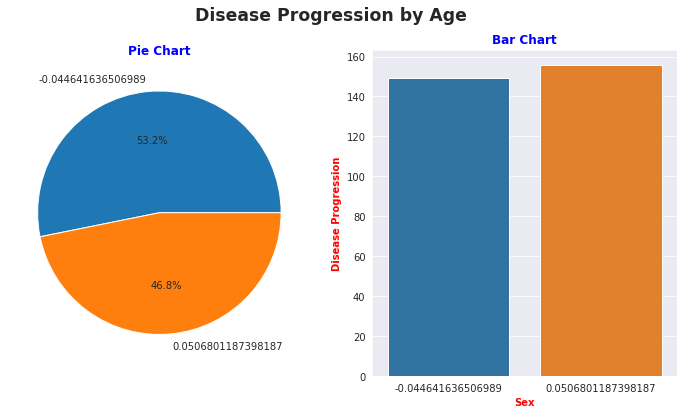

In [ ]:
create_bar_and_pie_chart(diabetes_df, 'sex', 'disease_progression')

From both pie and bar chart above, despite having limited information about which color represents which gender, we can still conclude that neither male nor female patients tend to have higher possibility of having higher diabetes disease one year after baseline.

# Multi-variable Analysis

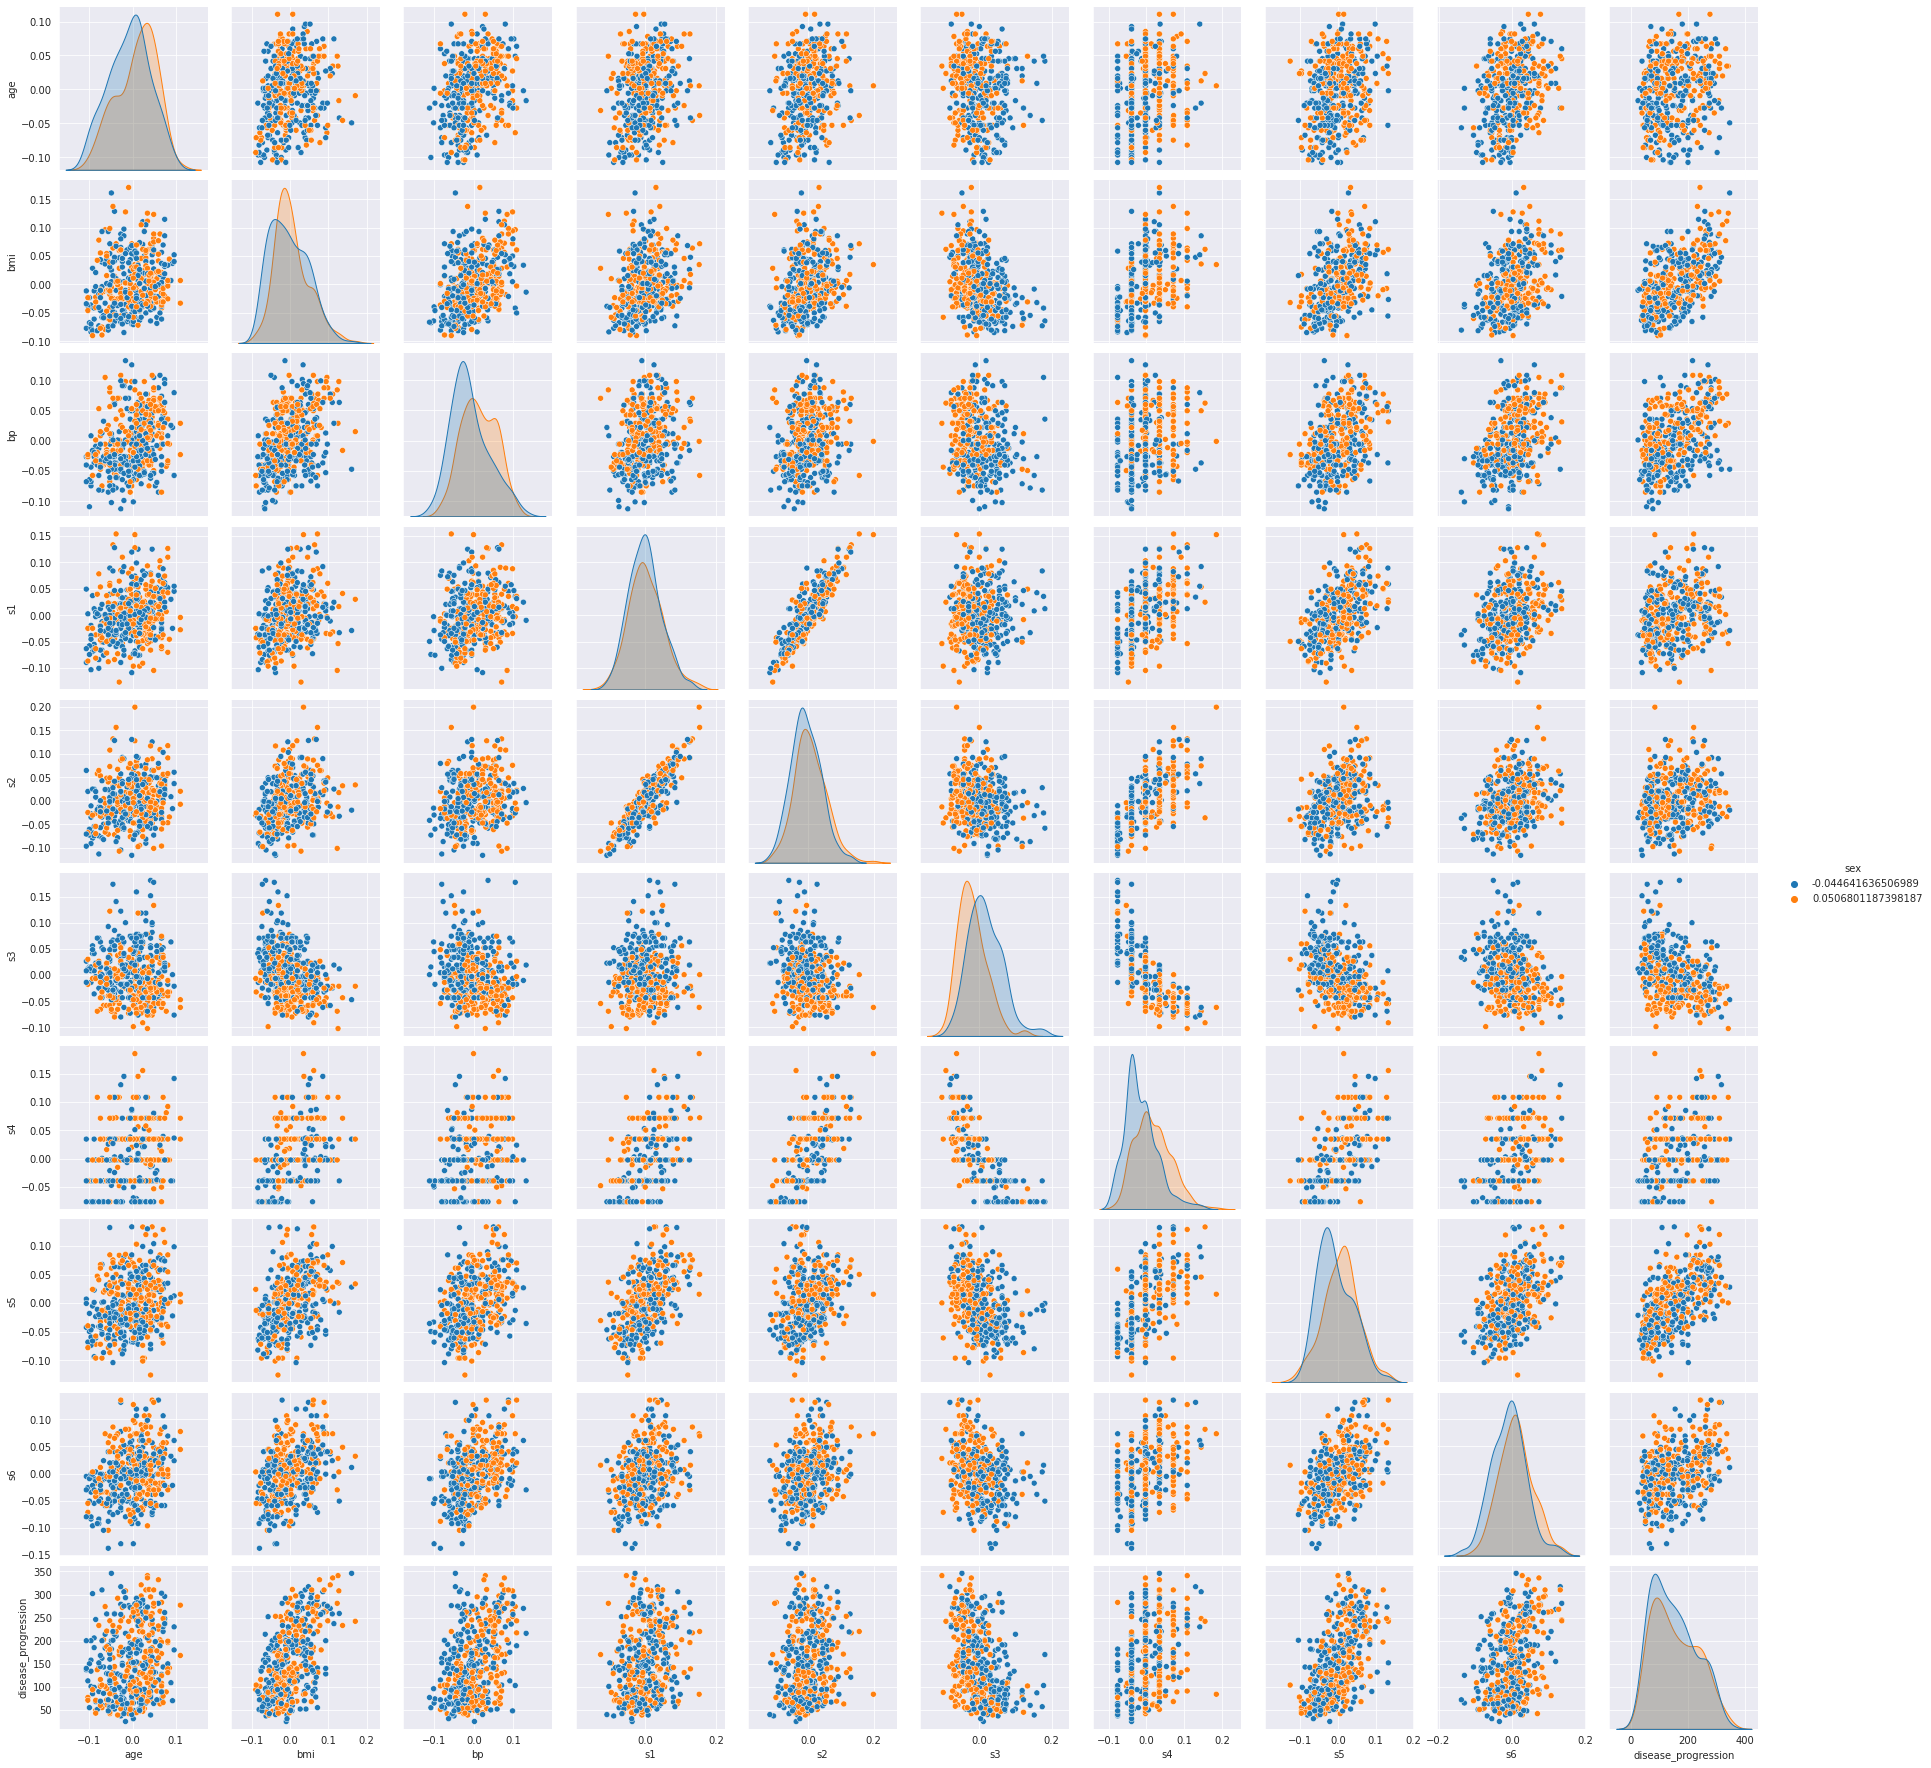

In [ ]:
sns.pairplot(diabetes_df, hue = 'sex')
plt.show()

View the correlation of the disease progression with all features in a single figure using heatmap.

In [ ]:
diabetes_df['sex'] = diabetes_df['sex'].astype(float)

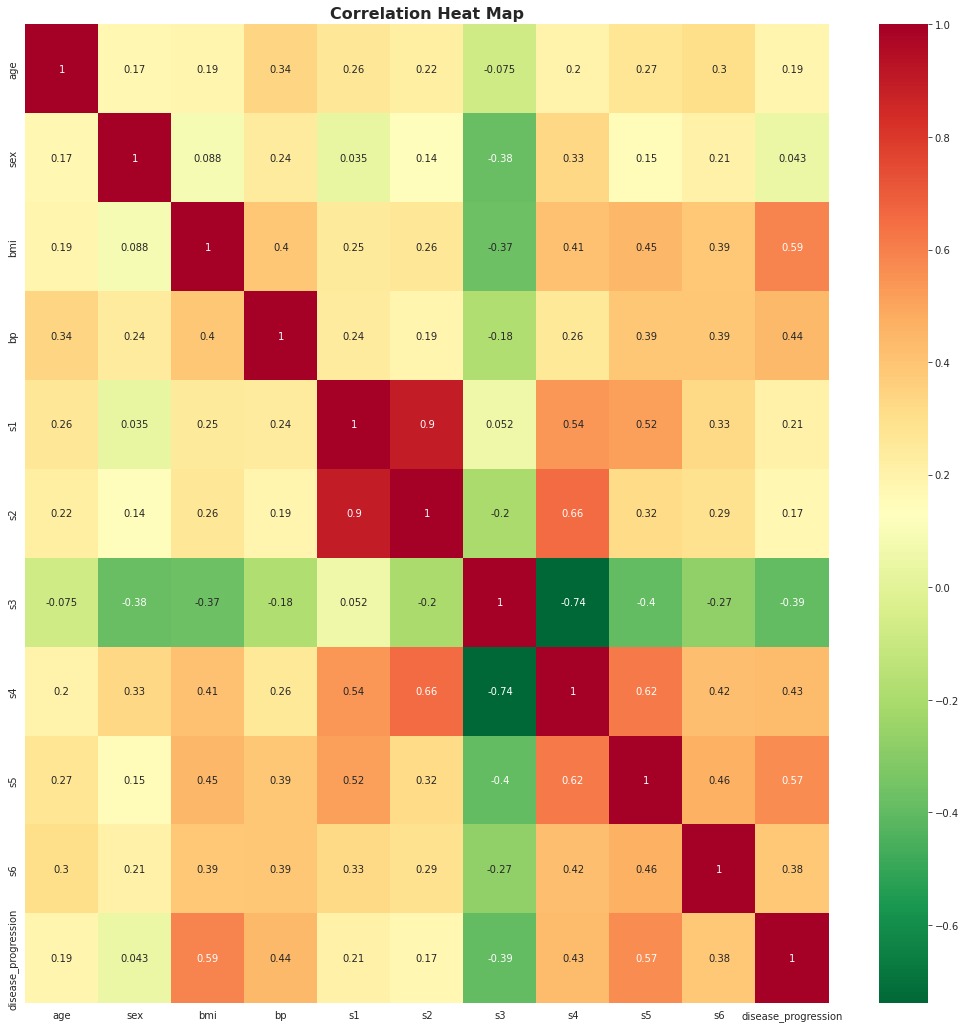

In [ ]:
plt.figure(figsize = (18, 18))
sns.heatmap(diabetes_df.corr(), annot = True, cmap = 'RdYlGn_r')
plt.title('Correlation Heat Map', fontsize = 16, fontweight = 'bold')
plt.show()

**Conclusion:**
- The Body Mass Index (BMI) is the feature with the highest correlation with the diabetes disease progression (one year after baseline).
- Blood Serum 1 and 2 are highly correlated variables (0.9). 
- Both gender and patient age do not contribute much to the disease progression.
- Serum 5 is the the feature with the highest correlation with the disease progression among all blood serums.

**Recommendation:**


(Data Exploration)

Since all variables in the dataset are scaled, it will be better if there are some information about the summary statistics, such as the mean and standard deviation of the unscaled data, so that we can simply descale the data to get the original one (although it's not mandatory). Getting the original / raw data will enable us to perform exploratory data analysis in more reasonable way since the context and the variable names are easier to interpret. 

(Business Decision)

As the correlation is the highest between both `bmi` and `s5` with `disease_progression` (> 0.5), those are the key features in predicting the target variable.

# Additional Experiment (Permutation Importance)

Besides visualizing data using scatter plot and conducting some hypothesis testings, we can do simple modelling to check about what features that contribute to `disease_progression` according to the model.

Separate features & target, then split the data into training and testing data.

In [ ]:
X = diabetes_df.drop('disease_progression', axis = 'columns')
y = diabetes_df['disease_progression']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

Make predictions and compare to the actual results.

In [ ]:
simple_model = XGBRegressor()
simple_model.fit(X_train, y_train)
predictions = simple_model.predict(X_test)
predictions

[12:25:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


array([143.45354 , 183.64984 , 158.07407 , 297.8018  , 122.59768 ,
       109.70924 , 257.64685 , 187.63509 , 161.35144 , 140.03464 ,
        98.4857  , 204.17964 ,  91.00305 , 241.70607 , 113.4265  ,
       109.105354, 221.51614 , 273.2184  , 207.4957  , 235.72069 ,
       191.7979  , 102.54483 ,  56.885723, 210.47757 , 142.19788 ,
       194.22713 , 215.69853 , 206.6133  ,  80.435394, 102.75786 ,
       193.11726 , 123.68253 , 149.8703  , 194.95354 , 149.67902 ,
       211.28622 , 116.89414 , 117.07123 , 171.80923 ,  76.2249  ,
        71.5697  ,  93.63977 , 201.74681 , 159.75366 , 180.44662 ,
        76.06644 , 108.48316 , 110.37925 ,  81.423   , 142.11696 ,
       117.42334 ,  79.880424, 143.96713 ,  96.869125, 151.41339 ,
       143.24446 ,  95.31704 , 200.22313 ,  93.75114 ,  88.037186,
       171.5743  , 191.30986 , 107.287155,  86.37442 , 130.51839 ,
       239.5776  , 174.10237 , 191.7005  , 153.38577 , 114.42454 ,
       147.97957 , 199.7406  , 210.4747  ,  87.94418 ,  92.409

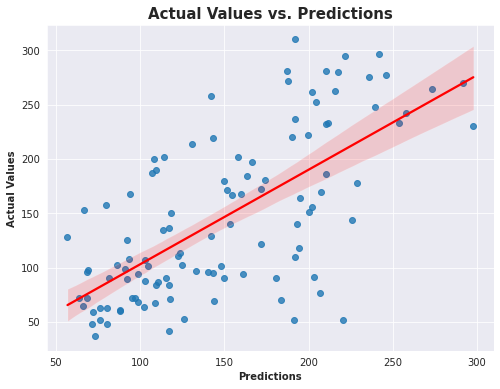

In [ ]:
plt.figure(figsize = (8, 6))
sns.regplot(x = predictions, y = y_test, line_kws = {'color': 'red'})
plt.title('Actual Values vs. Predictions', fontsize = 15, fontweight = 'bold')
plt.xlabel('Predictions', fontweight = 'bold')
plt.ylabel('Actual Values', fontweight = 'bold')
plt.show()

After predicting, simply display the weights of features and check for the maximum / minimum values.

In [ ]:
permutation_importance = PermutationImportance(simple_model, random_state = 42).fit(X_test, y_test)
eli5.show_weights(permutation_importance, feature_names = list(X_test.columns))

Weight,Feature
0.2726 ± 0.0918,s5
0.1642 ± 0.0965,bmi
0.0530 ± 0.0668,bp
0.0477 ± 0.0471,sex
0.0295 ± 0.0370,s6
0.0089 ± 0.0631,s3
-0.0015 ± 0.0420,age
-0.0072 ± 0.0446,s2
-0.0126 ± 0.0136,s4
-0.0215 ± 0.0156,s1


From the feature importance table above, we can clearly see that our XGBoost Regressor model thinks that the `s5` (blood serum 5) is the feature that contributes the most to `disease_progression`, followed by `bmi` (body mass index), and `bp` (average blood pressure).

Meanwhile the features that contribute the least to `disease_progression` are `s1`, `s4`, and `s2`.